# Times Series Modeling 
----

## Pre-Processing Data

In [2114]:
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import missingno as msno
from sklearn import metrics

In [2115]:
covid = pd.read_csv('../data/clean_data/covid_cases_us_clean.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
covid = covid[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
covid.set_index('submission_date', inplace=True)
covid.sort_index(inplace=True)

In [2116]:
covid

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [2117]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [2118]:
# Creating a copy of dataset to perform modeling
df = covid.copy()
df

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [2119]:
df = df.groupby(by=df.index).sum()
df

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0
...,...,...,...,...
2022-10-07,96491443,42558,1057306,314
2022-10-08,96502884,11441,1057365,59
2022-10-09,96516506,13622,1057428,63


## 1. ARIMA Models

We trying to build a Time Series on covid cases since the begining of the pandemic so first we need to check for some assumptions like stationarity, trends and seasonalities on the dataset.

In [2120]:
# dropping columns
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)
df = df.resample('W').mean()

In [2121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2020-01-26 to 2022-10-16
Freq: W-SUN
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   new_case  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [2122]:
# Run ADF test on original (non-differenced!) data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.321261
p-value           0.013954
dtype: float64

In [2123]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [2124]:
# Checking train tail
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [2125]:
# Checking the test head
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

### 1.1. Building a ARIMA(0,1,0)

In [2126]:
# Instantiate best model.
arima_010 = ARIMA(endog = y_train, order = (0, 1, 0))

# Fit ARIMA model.
model_010 = arima_010.fit()

# Generate predictions based on test set.
preds_010 = model_010.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_010 = model_010.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_010))

MSE:  1896377434.2340138


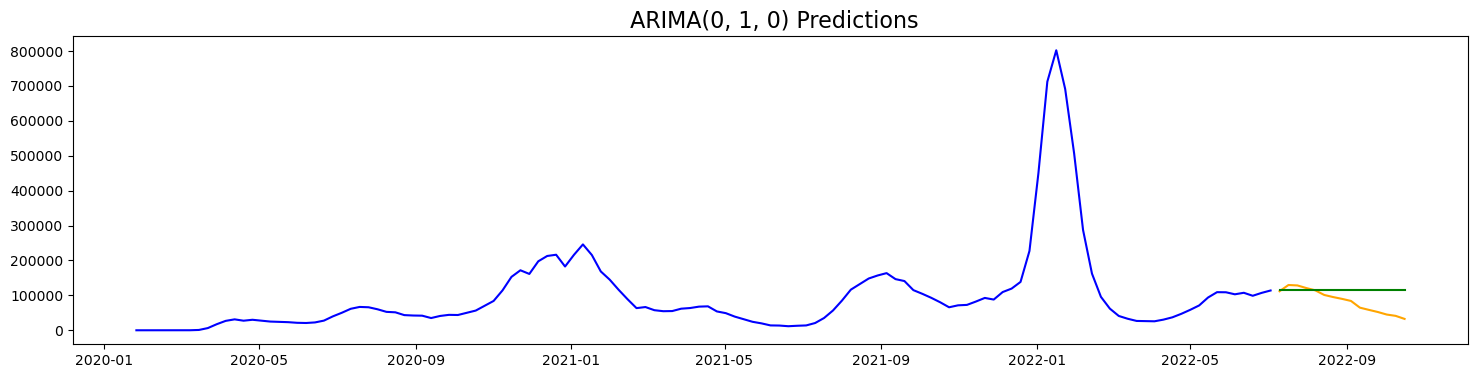

In [2127]:
# Plotting the model ARIMA(0,1,0)
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_010, color = 'green')

plt.title(label = ' ARIMA(0, 1, 0) Predictions', fontsize=16);

### 1.2. Building a ARIMA(3,0,1)

In [2128]:
# Instantiate best model.
arima_301 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_301 = arima_301.fit()

# Generate predictions based on test set.
preds_301 = model_301.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_301 = model_301.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_301))

MSE:  1106435440.419724


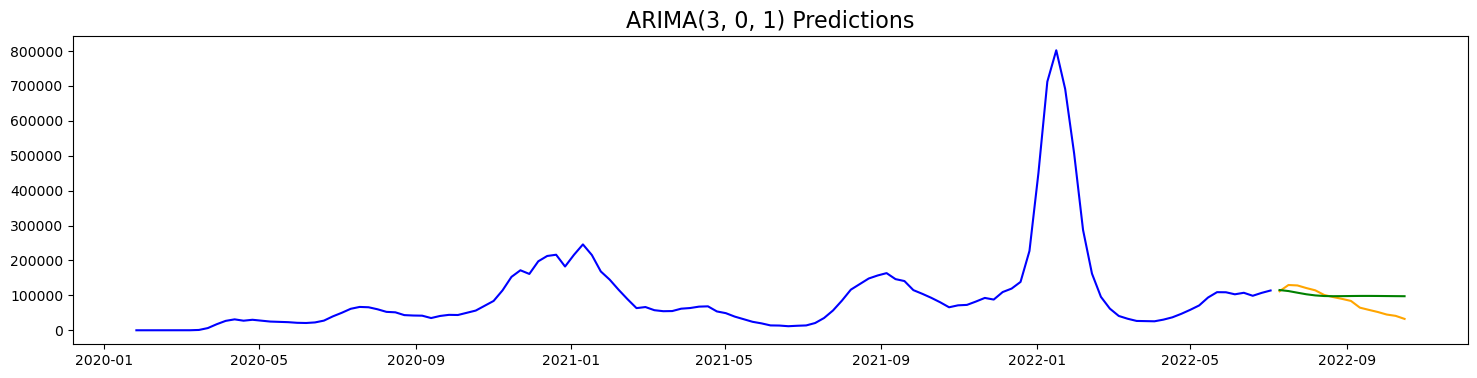

In [2129]:
# Plotting  the model ARIMA(3,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_301, color = 'green')

plt.title(label = 'ARIMA(3, 0, 1) Predictions', fontsize=16);

### 1.3. Building a ARIMA(52, 0, 1)

In [2130]:
# Instantiate best model.
arima_2201 = ARIMA(endog = y_train, order = (22, 0, 1))

# Fit ARIMA model.
model_2201 = arima_2201.fit()

# Generate predictions based on test set.
preds_2201 = model_2201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_2201 = model_2201.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_2201))

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE:  1411288958.4323306


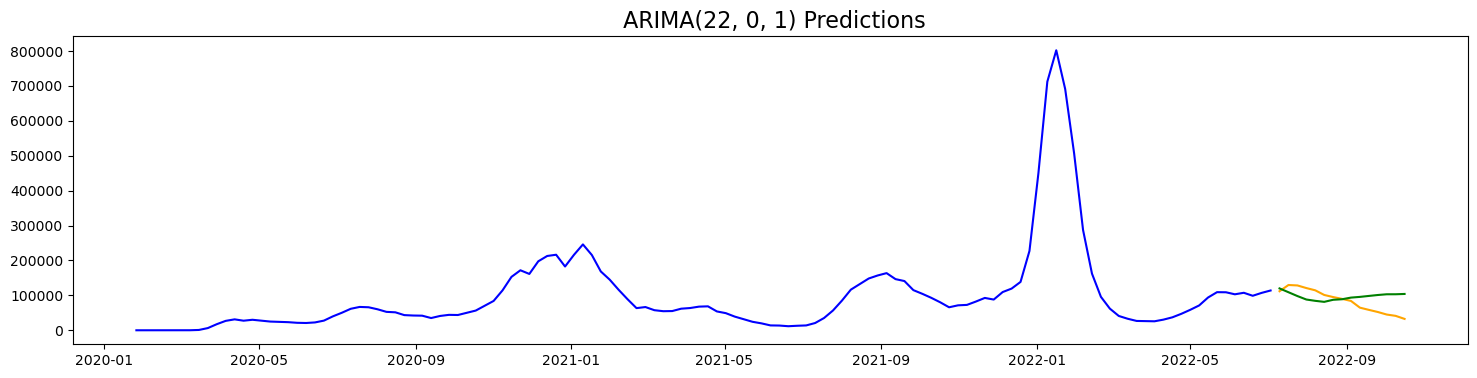

In [2131]:
# Plotting  the model ARIMA(22,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_2201, color = 'green')

plt.title(label = ' ARIMA(22, 0, 1) Predictions', fontsize=16);

## 2. SARIMA Models

### 2.1. SARIMA(3, 0, 1) x (1, 1, 1, 22)

In [2132]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1, 1, 1, 22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04523D+01    |proj g|=  1.66716D+00

At iterate    5    f=  9.75048D+00    |proj g|=  2.63298D-02


 This problem is unconstrained.



At iterate   10    f=  9.74065D+00    |proj g|=  3.23227D-03

At iterate   15    f=  9.74050D+00    |proj g|=  4.57137D-04

At iterate   20    f=  9.74050D+00    |proj g|=  4.79306D-04

At iterate   25    f=  9.74042D+00    |proj g|=  6.11914D-03

At iterate   30    f=  9.74030D+00    |proj g|=  2.64458D-04

At iterate   35    f=  9.74028D+00    |proj g|=  1.81728D-03

At iterate   40    f=  9.73918D+00    |proj g|=  2.61683D-02

At iterate   45    f=  9.73043D+00    |proj g|=  1.53451D-01

At iterate   50    f=  9.67157D+00    |proj g|=  2.85017D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76   

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


716944558.8919765

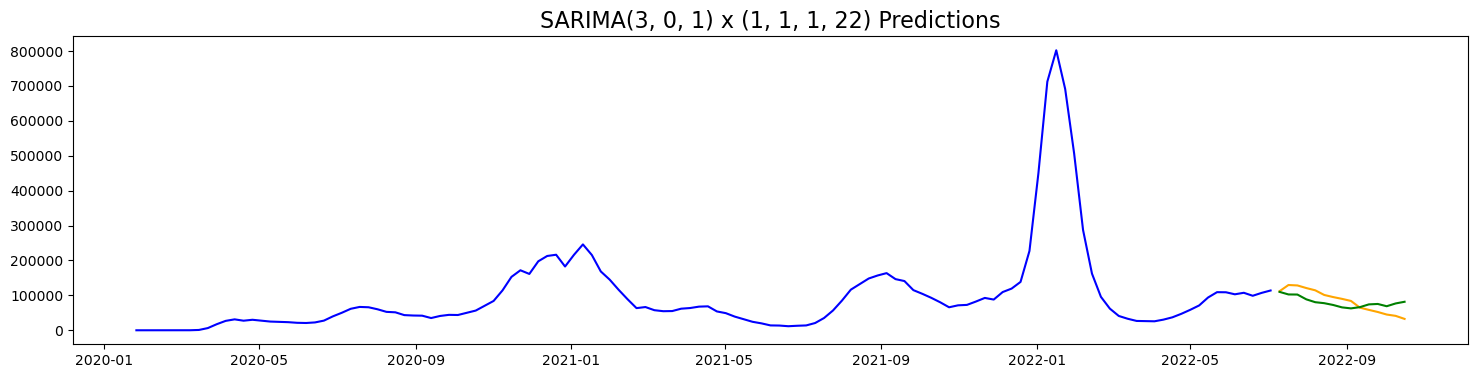

In [2133]:
# Plotting SARIMA
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'SARIMA(3, 0, 1) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

### 2.2. SARIMA(1, 0, 0) x (1, 1, 1, 22) (GridSearch Parameters)

In [2134]:
df['diff_1'] = df['new_case'].diff()
df['diff_2'] = df['new_case'].diff().diff()
df.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [2135]:
df.dropna(inplace=True)
df.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [2136]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [2137]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [2138]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [2139]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [2140]:
# Fit a SARIMA(1, 0, 0) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861503954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [2141]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.5619519

In [2142]:
#2022-07-10    111881.000000
#2022-07-17    129685.285714
#2022-07-24    128469.285714
#2022-07-31    120971.000000
#2022-08-07    114476.428571
print(model_sarima.predict('2022-07-10'))
print(y_test['2022-07-10'])
print(model_sarima.predict(pd.to_datetime('2022-07-17')))
print(y_test['2022-07-17'])
print(model_010.predict('2022-07-24'))
print(y_test['2022-07-24'])


2022-07-10    108598.210508
Freq: W-SUN, dtype: float64
111881.0
2022-07-17    103467.031396
Freq: W-SUN, dtype: float64
129685.28571428571
2022-07-24    113983.857143
Freq: W-SUN, dtype: float64
128469.28571428571


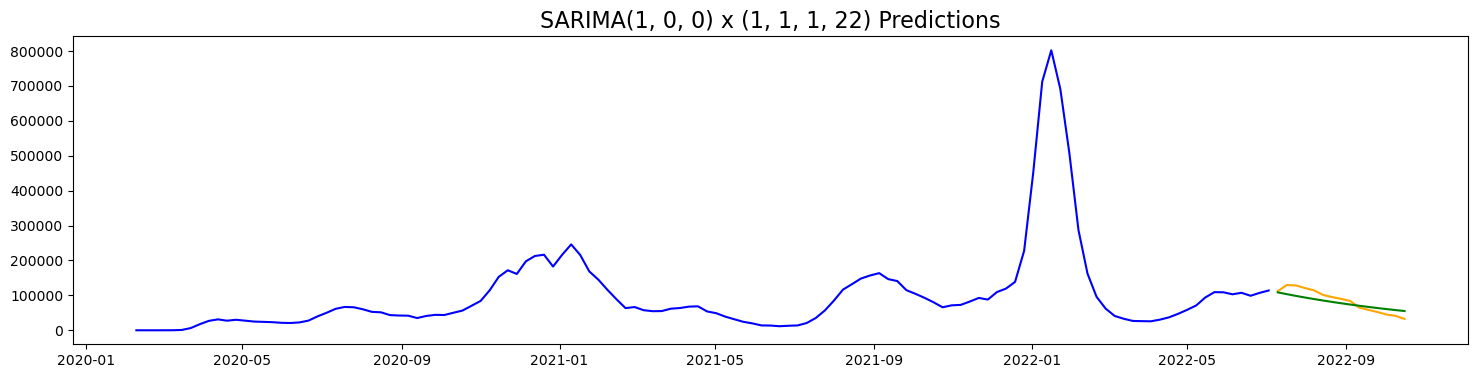

In [2143]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

In [2144]:
# Starting MSE and (P, D, Q).
def my_gridsearch():
    mse = 99 * (10 ** 16)
    final_p = 0
    final_d = 0
    final_q = 0
    final_P = 0
    final_D = 0
    final_Q = 0

    for p in range(2):
        for q in range(2):
            for d in range(2):
                for P in range(3):
                    for Q in range(3):
                        for D in range(3):
                            try:
                                sarima = SARIMAX(endog = y_train,
                                                order = (p, d, q),              # (p, d, q)
                                                seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                                
                                print(P, D, Q)
                                # Fit SARIMA model.
                                model = sarima.fit()
                                preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
                                print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                                # Save for final report.
                                if mse > metrics.mean_squared_error(y_test, preds_sarima):
                                    mse = metrics.mean_squared_error(y_test, preds_sarima)
                                    
                                    final_p = p
                                    final_d = d
                                    final_q = q
                                    final_P = P
                                    final_D = D
                                    final_Q = Q
                            except:

                                    pass
        print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
        print(f'This model has an MSE of {mse}.')
    return print('Gridsearach Done!')

In [2145]:
#my_gridsearch()

In [2146]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147

# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467

# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### 2.2. SARIMA(1, 0, 0) x (1, 0, 0, 12) (GridSearch Parameters)

In [2147]:
# Fit a SARIMA(1, 0, 0) x (1,0,0,12) model.
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(1,0,0,12))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22523D+01    |proj g|=  3.74687D-01

At iterate    5    f=  1.21645D+01    |proj g|=  3.32853D-03

At iterate   10    f=  1.21644D+01    |proj g|=  4.30767D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.308D-07   1.216D+01
  F =   12.164388087270764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


368711930.3676137

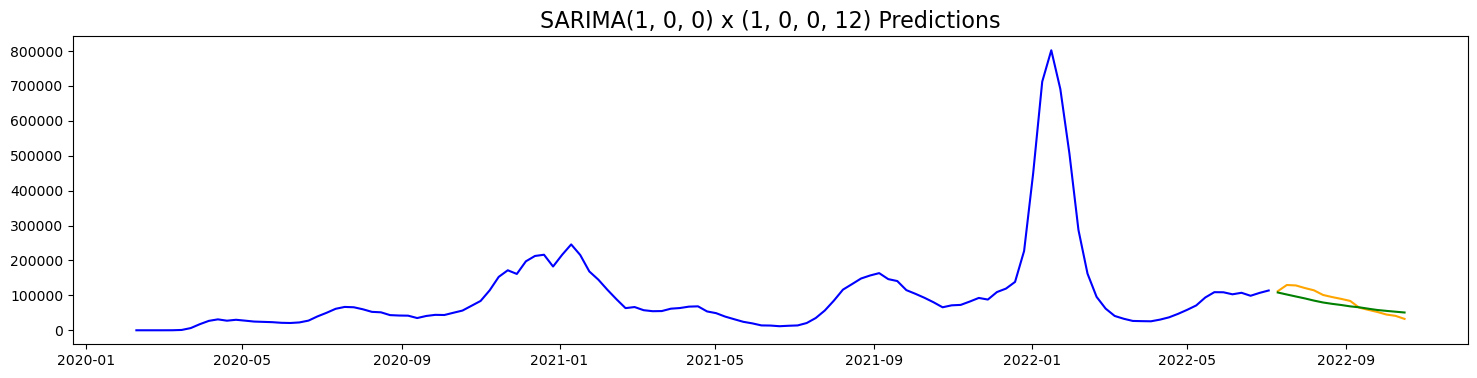

In [2148]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();

## 3. Multivariate Time Series Models
____

In [2149]:
# Import VAR
from statsmodels.tsa.api import VAR

In [2150]:
df_var = pd.read_csv('../data/data_nc_VAR_Model.csv')
df_var = df_var.rename(columns={'submission_date': 'Date'})
df_var['Date'] = pd.to_datetime(df_var['Date'])
df_var.set_index('Date', inplace=True)
df_var.head(3)


,new_case,new_death,Admin_Dose_1_Daily,Administered_Dose1_Pop_Pct,Series_Complete_Daily,Series_Complete_Pop_Pct,Booster_Daily,Additional_Doses_Vax_Pct,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips >=500
Date,,,,,,,,,,,,
2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1853446.0,8634638.0,39155121.0,16466.0
2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1894941.0,8593143.0,38740334.0,18670.0
2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1864086.0,8623998.0,39691859.0,19378.0


In [2151]:

df_var = df_var.rename(columns={'Series_Complete_Daily': 'series_complete'})
df_var = df_var.rename(columns={'Number of Trips >=500': 'trips_500'})

In [2152]:
df_nc_var = df_var[['new_case', 'new_death', 'trips_500']] 

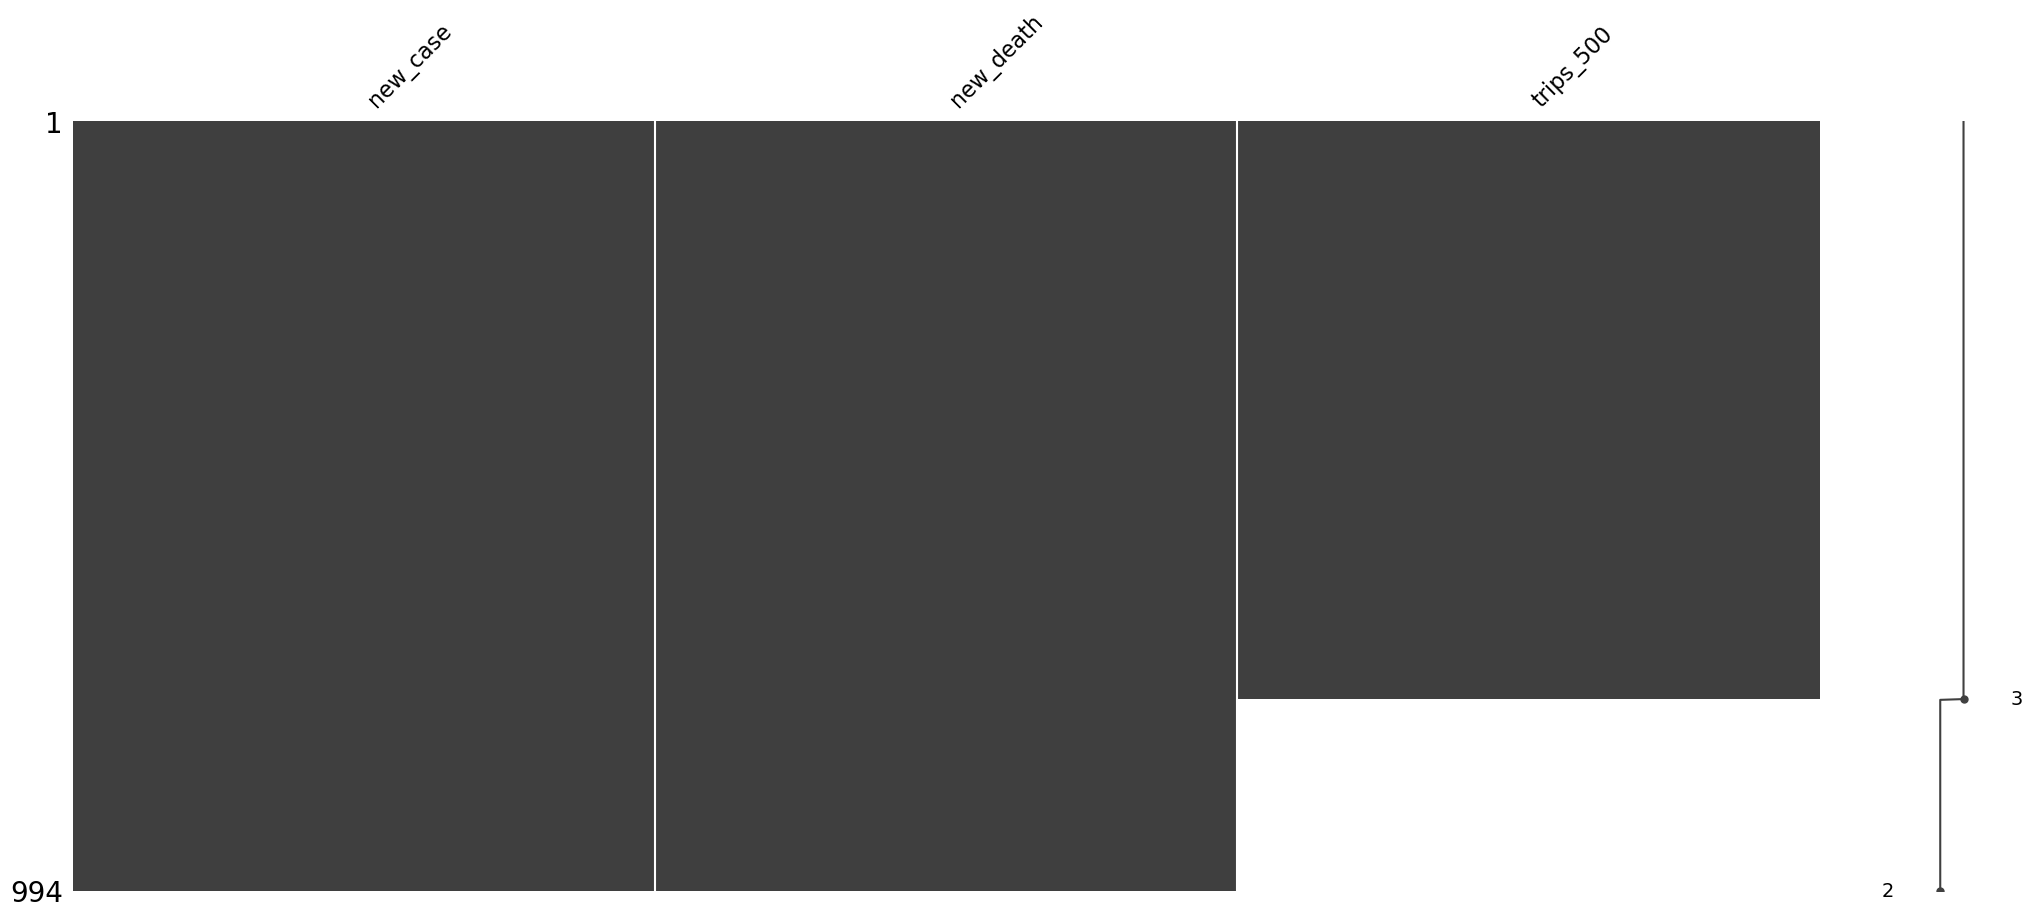

In [2153]:
msno.matrix(df_nc_var);

In [2154]:
df_nc_var.isnull().sum()

new_case       0
new_death      0
trips_500    248
dtype: int64

Filling not_at_home with max value because as vaccination happens not_at_home will increased slowly (life is backing to normal)

In [2155]:
#df_nc_var['trips_500'].fillna(df_nc_var['trips_500'].mode(), inplace=True)
df_nc_var.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2394585737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var.dropna(inplace=True)


In [2156]:
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2020-01-22 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   746 non-null    int64  
 1   new_death  746 non-null    int64  
 2   trips_500  746 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 23.3 KB


### Model
---

In [2157]:
df_nc_var.head()

,new_case,new_death,trips_500
Date,,,
2020-01-22,0,0,16466.0
2020-01-23,0,0,18670.0
2020-01-24,0,0,19378.0
2020-01-25,0,0,17478.0
2020-01-26,0,0,19183.0


In [2158]:
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2020-01-22 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   746 non-null    int64  
 1   new_death  746 non-null    int64  
 2   trips_500  746 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 23.3 KB


In [2159]:
df_nc_var.drop(df_nc_var[df_nc_var['new_case']==0].index, inplace=True)
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-03-03 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   699 non-null    int64  
 1   new_death  699 non-null    int64  
 2   trips_500  699 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 21.8 KB


/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


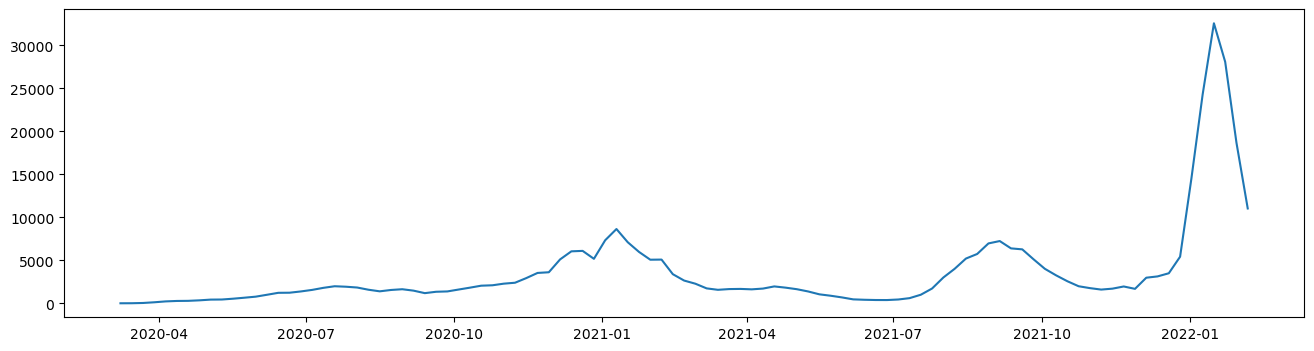

In [2160]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['new_case'].resample('W').mean());



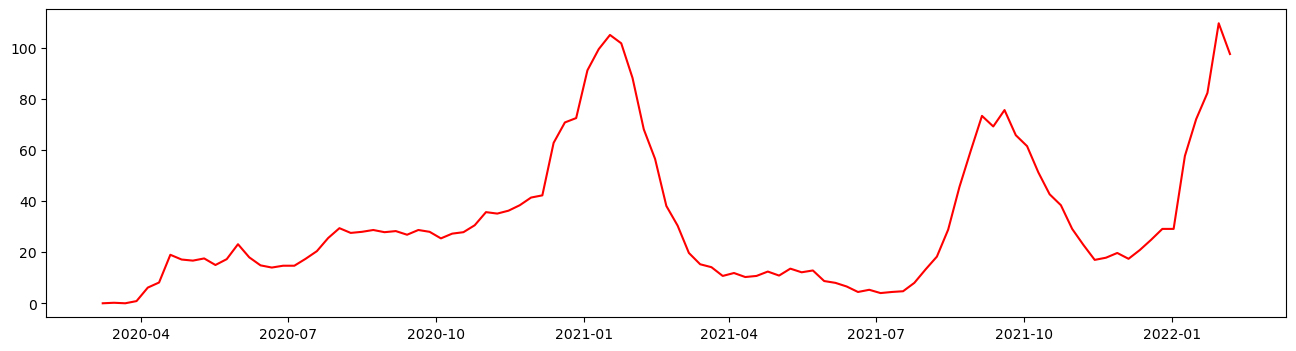

In [2161]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['new_death'].resample('W').mean(), color='red');

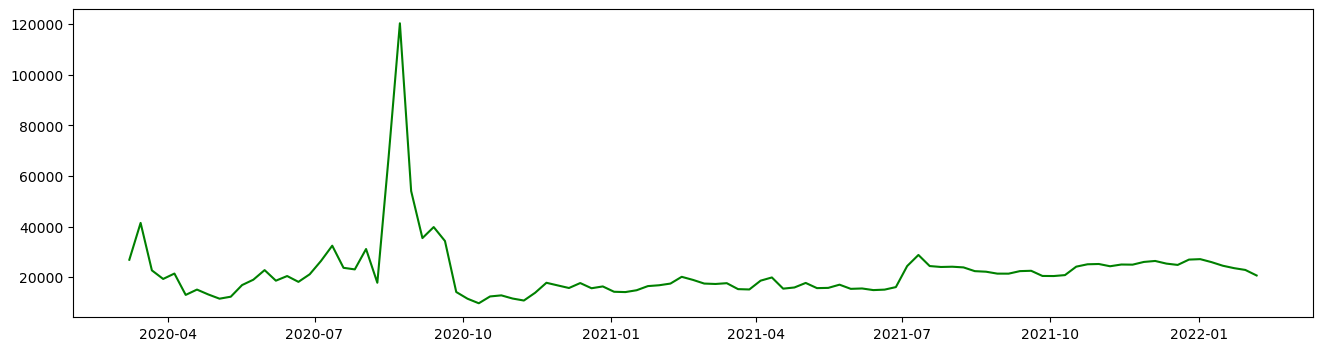

In [2162]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['trips_500'].resample('W').mean(), color='green');

In [2163]:
df_nc_var.isnull().sum()

new_case     0
new_death    0
trips_500    0
dtype: int64

#### 1. Checking Stationarity

In [2164]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [2165]:
# Run ADF test on the original New Death data.
interpret_dftest(adfuller(df_nc_var['new_death']))

Test Statistic    -2.819421
p-value            0.055553
Lag Used          17.000000
dtype: float64

In [2166]:
# Run ADF test on the first-differcenced New Death data.
interpret_dftest(adfuller(df_nc_var['new_death'].diff().dropna()))


Test Statistic    -3.614011
p-value            0.005499
Lag Used          16.000000
dtype: float64

In [2167]:
# Create column.
df_nc_var['first_diff_new_death'] = df_nc_var['new_death'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2047688624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var['first_diff_new_death'] = df_nc_var['new_death'].diff()


In [2168]:
df_nc_var.head(2)

,new_case,new_death,trips_500,first_diff_new_death
Date,,,,
2020-03-03,1,0,24011.0,NaN
2020-03-07,1,0,29765.0,0.0


Assuming $\alpha=0.01$, take two minutes to achieve stationarity for `new case` and `not_at_home`. If needed, create the columns we want to model.

In [2169]:
# Run ADF test on the original New Case data.
interpret_dftest(adfuller(df_nc_var['new_case']))

Test Statistic    -2.873279
p-value            0.048545
Lag Used          19.000000
dtype: float64

In [2170]:
# Run ADF test on the original first-differcenced New Case data.
interpret_dftest(adfuller(df_nc_var['new_case'].diff().dropna()))

Test Statistic    -5.069064
p-value            0.000016
Lag Used          20.000000
dtype: float64

In [2171]:
# Create column.
df_nc_var['first_diff_new_case'] = df_nc_var['new_case'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1583640008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var['first_diff_new_case'] = df_nc_var['new_case'].diff()


In [2172]:
# Run ADF test on the original trips_500 data.
interpret_dftest(adfuller(df_nc_var['trips_500']))

Test Statistic    -3.326031
p-value            0.013754
Lag Used          20.000000
dtype: float64

In [2173]:
df_nc_var.head(2)

,new_case,new_death,trips_500,first_diff_new_death,first_diff_new_case
Date,,,,,
2020-03-03,1,0,24011.0,NaN,NaN
2020-03-07,1,0,29765.0,0.0,0.0


#### 2. Train/test split.

In [2174]:
# Subset our data.
covid_df = df_nc_var[['first_diff_new_death', 'first_diff_new_case', 'trips_500']]

# Let's get rid of rows containing missing values.
covid_df.dropna(inplace = True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1972607083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df.dropna(inplace = True)


In [2175]:
train, test = train_test_split(covid_df,
                               test_size = 0.1,
                              shuffle=False)

In [2176]:
train.tail()

,first_diff_new_death,first_diff_new_case,trips_500
Date,,,
2021-11-23,-2.0,449.0,23911.0
2021-11-24,2.0,549.0,26750.0
2021-11-25,-6.0,-50.0,27928.0
2021-11-26,6.0,-678.0,26696.0
2021-11-27,-2.0,-494.0,26245.0


In [2177]:
test.head()

,first_diff_new_death,first_diff_new_case,trips_500
Date,,,
2021-11-28,10.0,472.0,26886.0
2021-11-29,-12.0,65.0,26885.0
2021-11-30,-4.0,821.0,25963.0
2021-12-01,3.0,964.0,25272.0
2021-12-02,4.0,462.0,25951.0


#### 3. Determine correct lag order $p$.

We can check out autocorrelation plots and partial autocorrelation plots to attempt to figure out how many previous values of **each variable** we want in our model.

Suppose I select $p=2$.

$$
\begin{eqnarray*}
Y^{(d)}_{1,t} &=& \beta_0 + \beta_1Y^{(d)}_{1,t-1} + \beta_2Y^{(d)}_{1,t-2} + \beta_3Y^{(d)}_{2,t-1} + \beta_4Y^{(d)}_{2,t-2} + \beta_5Y^{(d)}_{3,t-1} + \beta_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{2,t} &=& \gamma_0 + \gamma_1Y^{(d)}_{1,t-1} + \gamma_2Y^{(d)}_{1,t-2} + \gamma_3Y^{(d)}_{2,t-1} + \gamma_4Y^{(d)}_{2,t-2} + \gamma_5Y^{(d)}_{3,t-1} + \gamma_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{3,t} &=& \delta_0 + \delta_1Y^{(d)}_{1,t-1} + \delta_2Y^{(d)}_{1,t-2} + \delta_3Y^{(d)}_{2,t-1} + \delta_4Y^{(d)}_{2,t-2} + \delta_5Y^{(d)}_{3,t-1} + \delta_6Y^{(d)}_{3,t-2}
\\
\end{eqnarray*}
$$

However, we can automate the selection of $p$ using a metric called the Akaike information criterion, or the AIC.

##### AIC

The AIC is a metric that is commonly used for time series models or in more "statistics-oriented" fields.
- Recall that models are just simplifications of reality. AIC attempts to measure how much information we lose when we simplify reality with a model.
- The lower the AIC, the better!
- More details can be found at the [Wikipedia page](https://en.wikipedia.org/wiki/Akaike_information_criterion).

We can actually find a good value of $p$ when we fit our model!

#### 4. Fit model.

In [2178]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [2179]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(maxlags = 15, # what is the largest possible value of p?
                 ic = 'aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [2180]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Oct, 2022
Time:                     12:10:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    34.2364
Nobs:                     614.000    HQIC:                   33.6689
Log likelihood:          -12710.2    FPE:                2.92208e+14
AIC:                      33.3078    Det(Omega_mle):     2.38507e+14
--------------------------------------------------------------------
Results for equation first_diff_new_death
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.065303         0.565795           -0.115           0.908
L1.first_diff_new_death         -0.784072         0.042048          -18.647           0.000
L

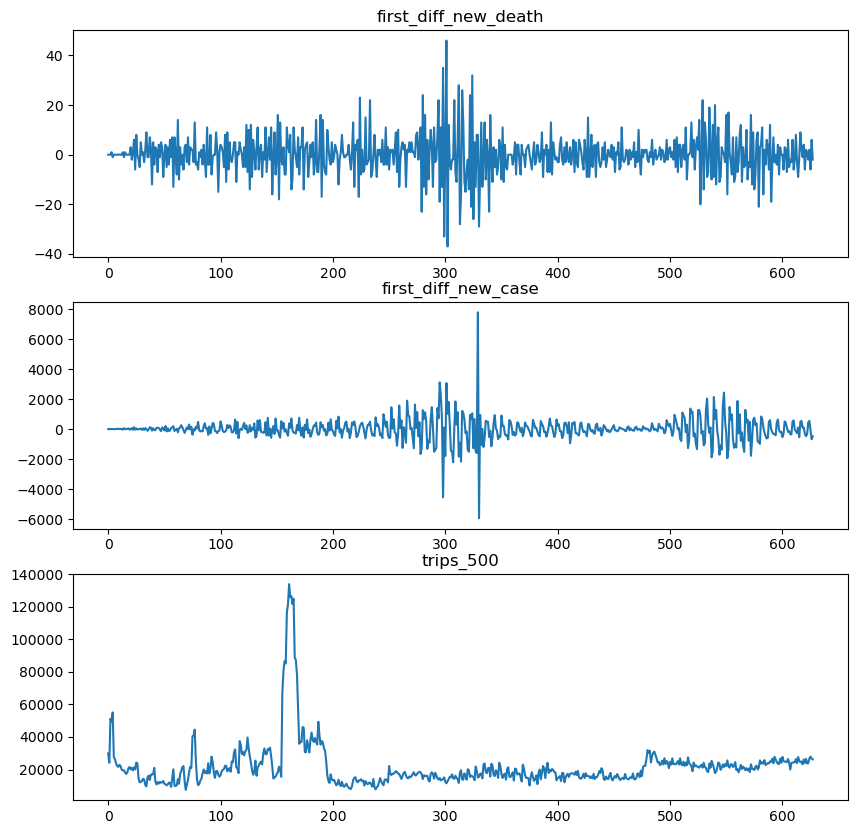

In [2181]:
# Plot our training data.
ts_model.plot();

#### 5. Generate forecasts.

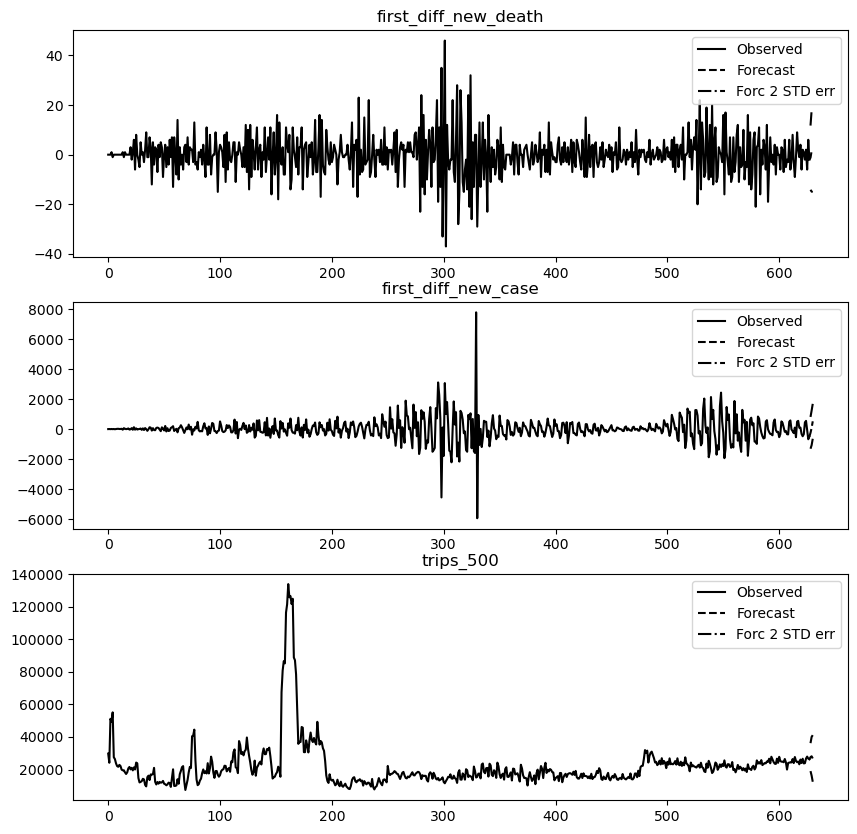

In [2182]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

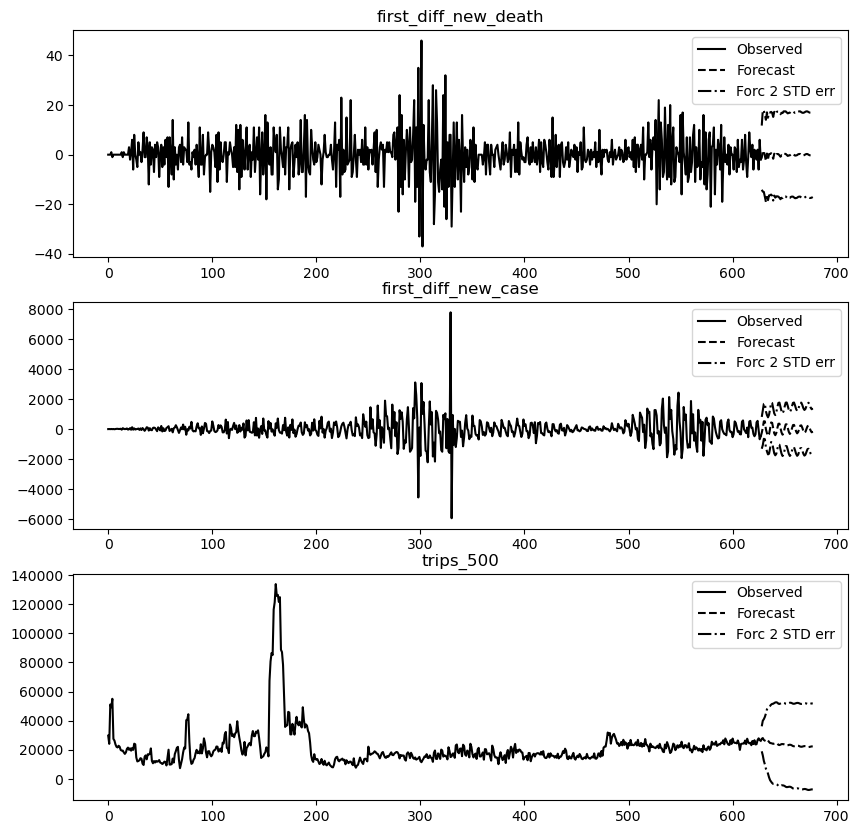

In [2183]:
# Plot the forecast looking 50 steps ahead.
ts_model.plot_forecast(50);

In [2184]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1)

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04]])

In [2185]:
# Generate a forecast five steps ahead.
ts_model.forecast(train.values, 5)

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04],
       [ 1.49215039e+00,  8.31937701e+01,  2.81278375e+04],
       [ 1.36426820e+00,  5.19512755e+02,  2.67858209e+04],
       [-4.83163533e-01,  5.15574582e+02,  2.63509753e+04],
       [-2.49990939e+00, -1.81769158e+01,  2.59999347e+04]])

In [2186]:
test.shape

(70, 3)

In [2187]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, test.shape[0])

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04],
       [ 1.49215039e+00,  8.31937701e+01,  2.81278375e+04],
       [ 1.36426820e+00,  5.19512755e+02,  2.67858209e+04],
       [-4.83163533e-01,  5.15574582e+02,  2.63509753e+04],
       [-2.49990939e+00, -1.81769158e+01,  2.59999347e+04],
       [ 4.46749584e-01, -2.77301922e+02,  2.68853324e+04],
       [-1.72585956e+00, -4.51712164e+02,  2.64178034e+04],
       [ 2.33079387e-01, -3.46145796e+02,  2.54659210e+04],
       [ 3.12754681e-01,  2.21134769e+01,  2.47204210e+04],
       [ 5.88890631e-01,  4.45873466e+02,  2.46080466e+04],
       [ 1.51730452e-01,  4.13578378e+02,  2.44045802e+04],
       [-1.64609832e+00,  5.75059144e+01,  2.41463295e+04],
       [ 3.97221960e-01, -2.86590331e+02,  2.43602799e+04],
       [-3.90469470e-01, -4.06580100e+02,  2.46241370e+04],
       [ 1.84512393e-01, -2.55713567e+02,  2.45764696e+04],
       [ 2.78239593e-01,  6.97094026e+01,  2.42590540e+04],
       [ 2.15012712e-01,  3.55785821e+02

#### 6. Evaluate model (and forecasts, if possible).

In [2188]:
# We'll use MSE
from sklearn.metrics import mean_squared_error, r2_score

In [2189]:
# Save forecasted values
forecast = ts_model.forecast(train.values, test.shape[0])

In [2190]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_new_death data is: 131.4485
The test MSE on the first_diff_new_case data is: 20630275.4318
The test MSE on the trips_500 data is: 7333887.0672


In [2191]:
# Loop through columns and get R2 for each
for i in range(test.shape[1]):
    print(f'The test R2 on the {test.columns[i]} data is: {round(r2_score(test.values[:, i], forecast[:, i]), 4)}')

The test R2 on the first_diff_new_death data is: -0.0392
The test R2 on the first_diff_new_case data is: 0.0328
The test R2 on the trips_500 data is: -0.4614


## 4. Exogenous Time series Models
____

## eXogenous Predictors

In time series analysis, we spend most of our time focused on how we can quantify the relationship between $Y_t$ and $Y_{t-k}$ and then use that relationship to forecast values of $Y_t$.

Future performance of Dow Chemical probably isn't limited to just past performance of Dow Chemical. The performance of Dow Chemical will be based on a whole host of things: how well its competitors are doing, how agriculture is doing (one of Dow's focuses), and so on.

However, we can (and should!) still use $X$ variables in our data.
- In `statsmodels` and in various disciplines like econometrics, the $X$ variables are known as `exogenous`.
- More on exogenous/endogenous [here](http://www.statsmodels.org/stable/endog_exog.html).

In fact, the SARIMAX model stands for "Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model."

#### One important practical note: 
If you're going to fit a SARIMAX model, make sure that your $X$ variable makes sense - especially timewise.
> For example, if we want to forecast Dow Chemical stock volume for December 2018 based on Intel's stock volume, I probably shouldn't use Intel's stock volume in December 2018 as an input. (I'm forecasting a value of $Y$ when I wouldn't have access to that value of $X$.)

I should probably lag my $X$ variable by at least one time point. 


| Index | $DOW_t$ | $INTC_{t-1}$ |
|-------|---------|--------------|
| 1     | $DOW_1$ | NA           |
| 2     | $DOW_2$ | $INTC_1$     |
| 3     | $DOW_3$ | $INTC_2$     |
| 4     | $DOW_4$ | $INTC_3$     |

Remember: we did this above!
> `stocks['INTC_lag_1'] = stocks['INTC'].shift(1)`

In [2192]:
df_var.head()

,new_case,new_death,Admin_Dose_1_Daily,Administered_Dose1_Pop_Pct,series_complete,Series_Complete_Pop_Pct,Booster_Daily,Additional_Doses_Vax_Pct,Population Staying at Home,Population Not Staying at Home,Number of Trips,trips_500
Date,,,,,,,,,,,,
2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1853446.0,8634638.0,39155121.0,16466.0
2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1894941.0,8593143.0,38740334.0,18670.0
2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1864086.0,8623998.0,39691859.0,19378.0
2020-01-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2049145.0,8438939.0,38065676.0,17478.0
2020-01-26,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2175018.0,8313066.0,33393079.0,19183.0


In [2193]:
df_nc_var_ex = df_var[[ 'new_death', 'new_case', 'trips_500', 'series_complete']] 

<AxesSubplot:>

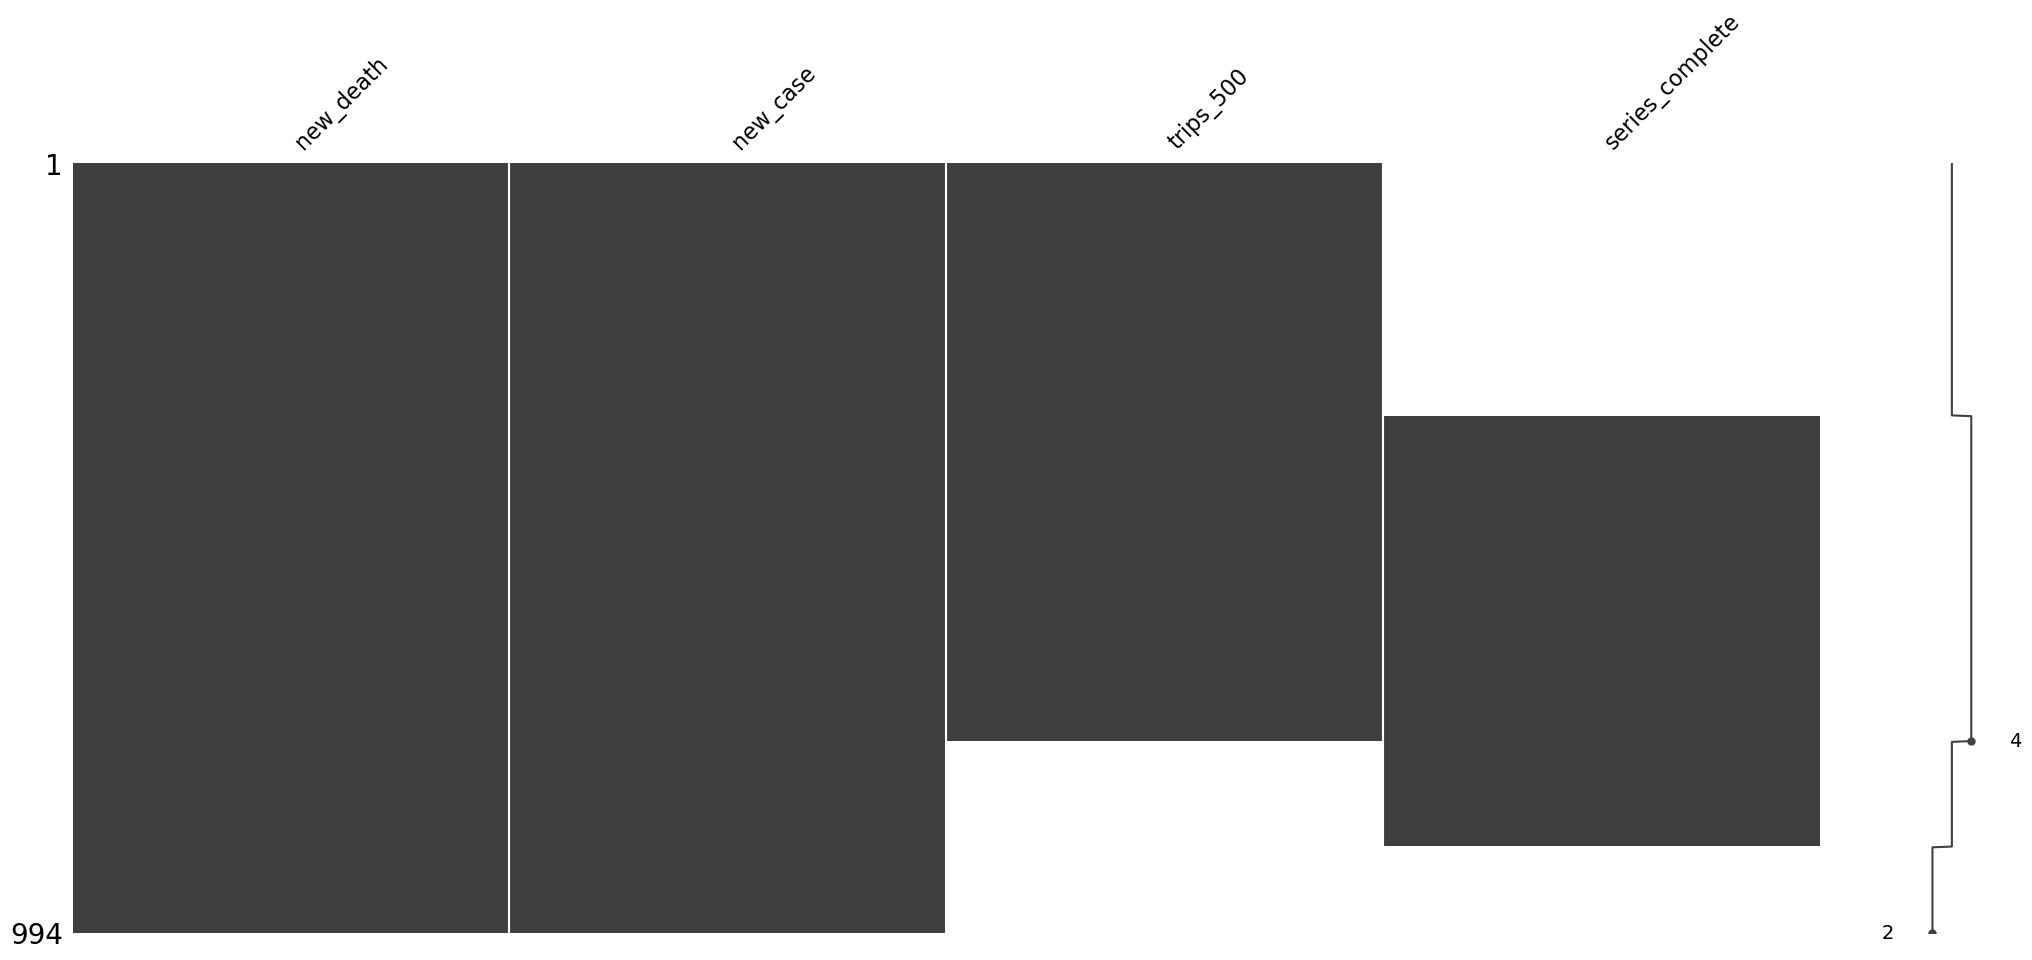

In [2194]:
msno.matrix(df_nc_var_ex)

In [2195]:
df_nc_var_ex['series_complete'].fillna(0, inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2196]:
df_nc_var_ex.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1797246450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var_ex.dropna(inplace=True)


In [2197]:
df_nc_var_ex.head()

,new_death,new_case,trips_500,series_complete
Date,,,,
2020-01-22,0,0,16466.0,0.0
2020-01-23,0,0,18670.0,0.0
2020-01-24,0,0,19378.0,0.0
2020-01-25,0,0,17478.0,0.0
2020-01-26,0,0,19183.0,0.0


In [2198]:
df_nc_var_ex = df_nc_var_ex.resample('W').mean()

#### 1. Stationarity

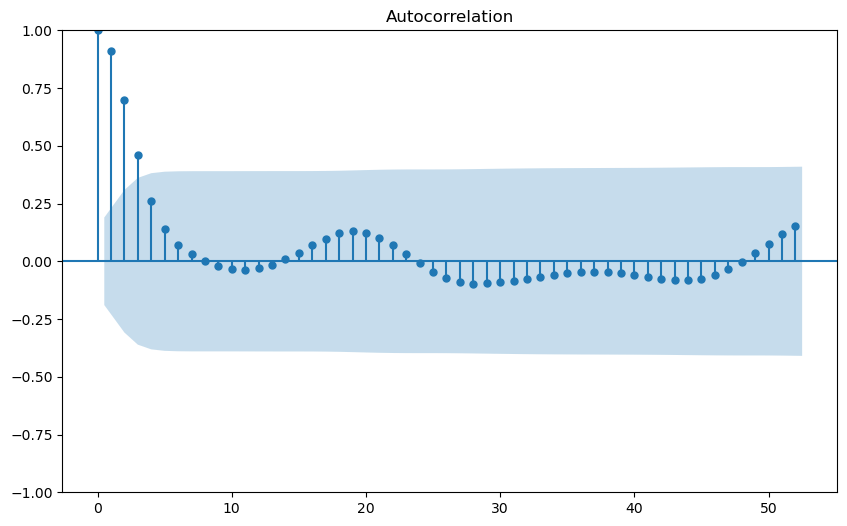

In [2199]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plt.rc("figure", figsize=(10,6))
plot_acf(df_nc_var_ex['new_case'], lags = 52);

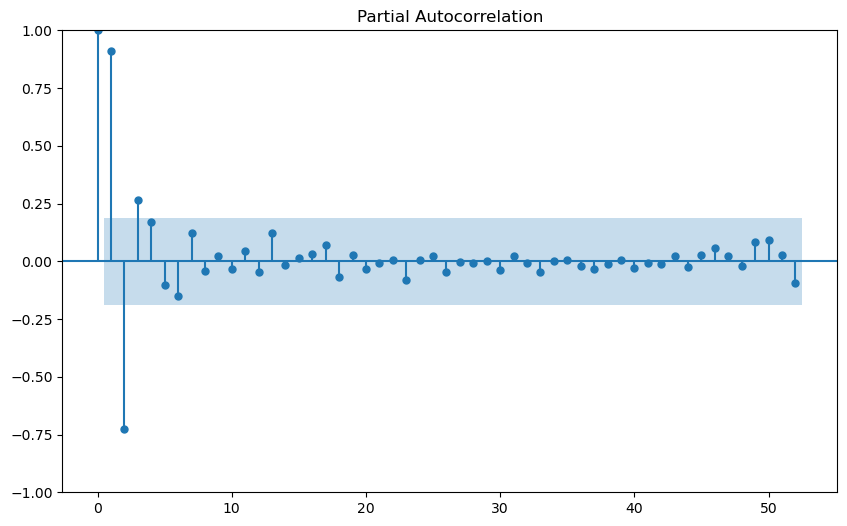

In [2200]:
plt.rc("figure", figsize=(10,6))
plot_pacf(df_nc_var_ex['new_case'],lags = 52, method='ywm' );

In [2201]:
# Run ADF test on the original New Death data.
interpret_dftest(adfuller(df_nc_var_ex['new_death']))


Test Statistic   -2.760576
p-value           0.064130
Lag Used          4.000000
dtype: float64

In [2202]:
# Run ADF test on the first-differcenced New Death data.
interpret_dftest(adfuller(df_nc_var_ex['new_death'].diff().dropna()))

Test Statistic   -4.577776
p-value           0.000142
Lag Used          3.000000
dtype: float64

In [2203]:
# Create column.
df_nc_var_ex['first_diff_new_death'] = df_nc_var_ex['new_death'].diff()

In [2204]:
# Run ADF test on the original vaccination data.
interpret_dftest(adfuller(df_nc_var_ex['series_complete']))

Test Statistic   -1.930462
p-value           0.317869
Lag Used          2.000000
dtype: float64

In [2205]:
# Run ADF test on the first-differcenced vaccination data.
interpret_dftest(adfuller(df_nc_var_ex['series_complete'].diff().dropna()))

Test Statistic   -1.088934e+01
p-value           1.236545e-19
Lag Used          1.000000e+00
dtype: float64

In [2206]:
# Create column.
df_nc_var_ex['first_diff_series_complete'] = df_nc_var_ex['series_complete'].diff()

In [2207]:
df_nc_var_ex.head()

,new_death,new_case,trips_500,series_complete,first_diff_new_death,first_diff_series_complete
Date,,,,,,
2020-01-26,0.0,0.0,18235.000000,0.0,NaN,NaN
2020-02-02,0.0,0.0,27296.714286,0.0,0.0,0.0
2020-02-09,0.0,0.0,37184.714286,0.0,0.0,0.0
2020-02-16,0.0,0.0,55274.285714,0.0,0.0,0.0
2020-02-23,0.0,0.0,45274.428571,0.0,0.0,0.0


In [2208]:
df_nc_var_ex.dropna(inplace=True)

In [2209]:
df_nc_var_ex = df_nc_var_ex[['first_diff_new_death','first_diff_series_complete']]

In [2210]:
df_nc_var_ex.head()

,first_diff_new_death,first_diff_series_complete
Date,,
2020-02-02,0.0,0.0
2020-02-09,0.0,0.0
2020-02-16,0.0,0.0
2020-02-23,0.0,0.0
2020-03-01,0.0,0.0


In [2211]:
train, test = train_test_split(df_nc_var_ex,
                               test_size = 0.1,
                              shuffle=False)

In [2212]:
# check train
train.tail()

,first_diff_new_death,first_diff_series_complete
Date,,
2021-10-24,-4.285714,-734.857143
2021-10-31,-9.285714,-2949.857143
2021-11-07,-6.285714,1625.571429
2021-11-14,-5.857143,-4334.428571
2021-11-21,0.857143,198.857143


In [2213]:
test.head()

,first_diff_new_death,first_diff_series_complete
Date,,
2021-11-28,1.857143,-1875.142857
2021-12-05,-2.285714,15798.000000
2021-12-12,3.428571,-3108.428571
2021-12-19,4.000000,-4823.000000
2021-12-26,4.285714,-4242.285714


In [2214]:
train.shape

(95, 2)

In [2215]:
test.shape

(11, 2)

In [2216]:
# Fit and visualize a SARIMAX(1, 1, 0) x (2, 0, 0, 22) model.

sarima = SARIMAX(endog = train['first_diff_new_death'].iloc[1:],
                 order = (1, 1, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 22), # (P, D, Q, S)
                 exog = train['first_diff_series_complete'].iloc[1:])

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 186.
preds = model.predict(start=1, end=11, exog=test[['first_diff_series_complete']])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04774D+00    |proj g|=  1.26176D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     40      2     0     0   5.122D-03   3.047D+00
  F =   3.0467753460643445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [2217]:
# Evaluate predictions.
print(mean_squared_error(test['first_diff_new_death'].iloc[0:], preds))

186.3684407960456


In [2218]:
preds

Date
2020-02-16    0.000000
2020-02-23    0.000000
2020-03-01    0.000000
2020-03-08    0.000000
2020-03-15    0.000000
2020-03-22    0.081257
2020-03-29   -0.019657
2020-04-05    0.425943
2020-04-12    3.376117
2020-04-19    3.416798
2020-04-26    7.037948
Freq: W-SUN, Name: predicted_mean, dtype: float64

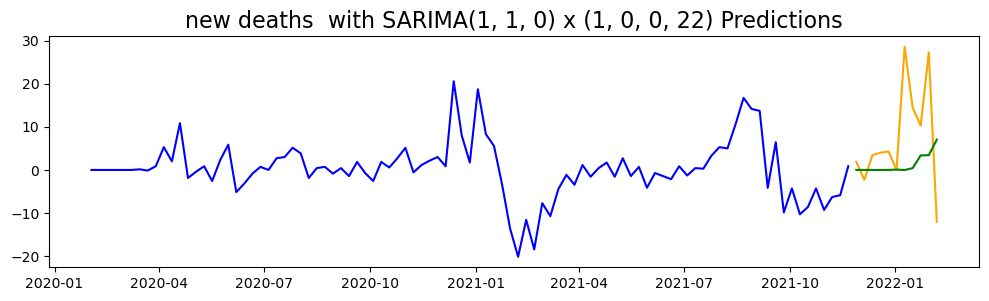

In [2219]:
# Plot data.
plt.figure(figsize=(12,3))
plt.plot(train['first_diff_new_death'], color = 'blue')
plt.plot(test['first_diff_new_death'], color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = 'new deaths  with SARIMA(1, 1, 0) x (1, 0, 0, 22) Predictions', fontsize=16)
plt.show();

## 5. TimeseriesGenerator with RNN Models
____

In [2220]:
df_var.columns

Index(['new_case', 'new_death', 'Admin_Dose_1_Daily',
       'Administered_Dose1_Pop_Pct', 'series_complete',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Additional_Doses_Vax_Pct',
       'Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'trips_500'],
      dtype='object')

In [2221]:
df_rnn =  df_var[['new_case', 'new_death', 'series_complete','trips_500']] 

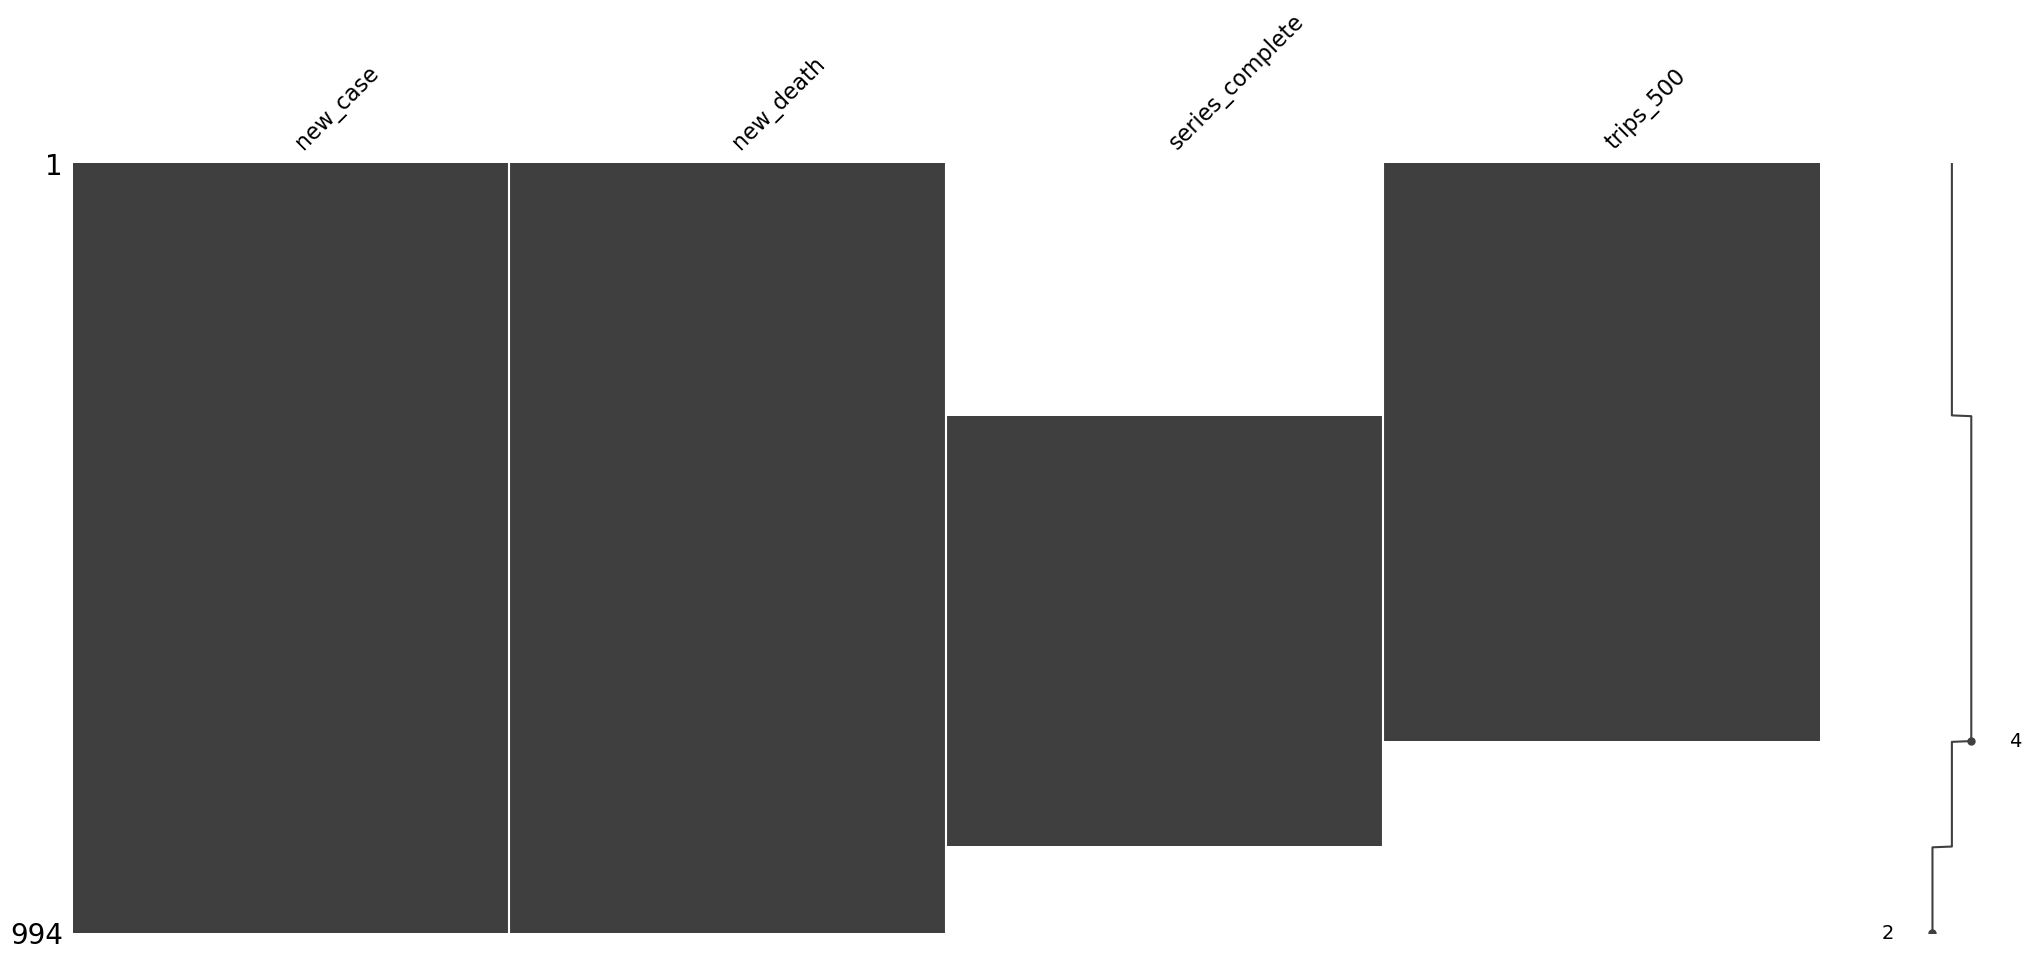

In [2222]:
msno.matrix(df_rnn);

In [2223]:
df_rnn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   new_case         994 non-null    int64  
 1   new_death        994 non-null    int64  
 2   series_complete  556 non-null    float64
 3   trips_500        746 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 38.8 KB


In [2224]:
# Putting zeros before vaccination started
df_rnn.loc['2020-01-22':'2022-01-01'].fillna(0,inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2225]:
# The number of trips it will not decrease as vaccination ia avaiable and life is backing to normal
df_rnn['trips_500'].fillna(df_nc_var['trips_500'].mean(), inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2226]:
df_rnn.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/3260562871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn.dropna(inplace=True)


### Stationarity

In [2227]:
# Run ADF test on the original data.
interpret_dftest(adfuller(df_rnn['new_case']))

Test Statistic    -3.846602
p-value            0.002465
Lag Used          21.000000
dtype: float64

In [2228]:
# Run ADF test on the originaldata.
interpret_dftest(adfuller(df_rnn['new_death']))

Test Statistic    -4.420095
p-value            0.000273
Lag Used          21.000000
dtype: float64

In [2229]:
# Run ADF test on the original data.
interpret_dftest(adfuller(df_rnn['series_complete']))

Test Statistic    -2.916328
p-value            0.043482
Lag Used          13.000000
dtype: float64

In [2230]:
# Run ADF test on the differenced-once data.
interpret_dftest(adfuller(df_rnn['series_complete'].diff().dropna()))

Test Statistic   -1.070019e+01
p-value           3.539560e-19
Lag Used          2.000000e+01
dtype: float64

In [2231]:
df_rnn['diff_first_series'] = df_rnn['series_complete'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1585055248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['diff_first_series'] = df_rnn['series_complete'].diff()


In [2232]:
# Run ADF test on the originaldata.
interpret_dftest(adfuller(df_rnn['trips_500']))

Test Statistic    -4.363856
p-value            0.000344
Lag Used          21.000000
dtype: float64

In [2233]:
df_rnn.head()

,new_case,new_death,series_complete,trips_500,diff_first_series
Date,,,,,
2020-01-22,0,0,0.0,16466.0,NaN
2020-01-23,0,0,0.0,18670.0,0.0
2020-01-24,0,0,0.0,19378.0,0.0
2020-01-25,0,0,0.0,17478.0,0.0
2020-01-26,0,0,0.0,19183.0,0.0


In [2234]:
# Subset our data.
df_nc_rnn = df_rnn[['new_death','new_case', 'diff_first_series', 'trips_500']]

# Let's get rid of rows containing missing values.
df_nc_rnn.dropna(inplace = True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2318484015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_rnn.dropna(inplace = True)


In [2235]:
df_nc_rnn.head()

,new_death,new_case,diff_first_series,trips_500
Date,,,,
2020-01-23,0,0,0.0,18670.0
2020-01-24,0,0,0.0,19378.0
2020-01-25,0,0,0.0,17478.0
2020-01-26,0,0,0.0,19183.0
2020-01-27,0,0,0.0,18608.0


In [2236]:
X = df_nc_rnn[['new_case']]#,'diff_first_series','trips_500']]
y = df_nc_rnn[['new_death']].values

In [2237]:
X.head()

,new_case
Date,
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0


In [2238]:
y

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  1],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  1],
       [  0],
       [  1],
       [  1],
       [  1],
       [  1],
       [  1],
       [  4],
       [  2],
       [  3],
       [  9],
      

In [2239]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [2240]:
X_train.tail()

,new_case
Date,
2021-11-08,1003
2021-11-09,1495
2021-11-10,2073
2021-11-11,2048
2021-11-12,1911


In [2241]:
X_test.head()

,new_case
Date,
2021-11-13,1645
2021-11-14,1745
2021-11-15,1205
2021-11-16,1705
2021-11-17,2253


### Scaling


You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [2242]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [2243]:
X_train_sc.shape

(660, 1)

## TimesSeries Generator
____

In [2244]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 3, batch_size = 64)

In [2245]:
batch_x, batch_y = train_sequences[0]

print(batch_x.shape)
print(batch_y.shape)

(64, 3, 1)
(64, 1)


In [2246]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 3, batch_size = 64)

## Modeling 
---

designing our RNN model:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a regression problem.

In [2247]:
train_sequences[0][0].shape

(64, 3, 1)

In [2248]:
# input shape
input_shape = train_sequences[0][0][0].shape
train_sequences[0][0][0].shape

(3, 1)

In [2249]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape = input_shape, return_sequences = True)) # True when next layer is RNN
model.add(GRU(8, return_sequences = False)) # False if next layer is Dense
model.add(Dense(4, activation = 'relu'))
# output layer
model.add(Dense(1, activation = 'relu'))

In [2250]:
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.0005),
              metrics = ['acc'])

history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    epochs = 100)

Epoch 1/100


2022-10-23 12:10:34.959902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.191026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.241066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.339745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/11 [=======>......................] - ETA: 0s - loss: 2724.2036 - acc: 0.2969

2022-10-23 12:10:35.439608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1474.0753 - acc: 0.0883

2022-10-23 12:10:36.031505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:36.094564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:36.133123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 78ms/step - loss: 1474.0753 - acc: 0.0883 - val_loss: 1892.9106 - val_acc: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 1471.0593 - acc: 0.0883 - val_loss: 1889.5620 - val_acc: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 1466.9474 - acc: 0.0883 - val_loss: 1886.2871 - val_acc: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 0s 19ms/step - loss: 1463.1646 - acc: 0.0883 - val_loss: 1882.5170 - val_acc: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 1460.4900 - acc: 0.0883 - val_loss: 1876.5665 - val_acc: 0.0000e+00
Epoch 6/100
11/11 [==============================] - 0s 19ms/step - loss: 1454.8442 - acc: 0.0883 - val_loss: 1872.1744 - val_acc: 0.0000e+00
Epoch 7/100
11/11 [==============================] - 0s 19ms/step - loss: 1450.4312 - acc: 0.0883 - val_loss: 1866.8948 - val_acc: 0.0000e+00
Epoch 8/100
11/11 

In [2251]:
model.predict('')

IndexError: list index out of range

In [ ]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model2 = Sequential()

model2.add(GRU(64, input_shape = (3, 8), return_sequences = True))
model2.add(Dropout(0.5))
model2.add(GRU(32, return_sequences = True))
model2.add(Dropout(0.5))
model2.add(GRU(16, return_sequences = False))
model2.add(Dropout(0.5))

model2.add(Dense(128, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = Adam(learning_rate = 0.001),
               loss = 'bce',
               metrics = ['acc'])

es = EarlyStopping(patience = 15)

history2 = model2.fit(train_sequences, epochs = 100, validation_data = test_sequences,
                      callbacks = [es], verbose = 0)

In [ ]:
plt.plot(history2.history['loss'], label = 'Train loss')
plt.plot(history2.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
pd.DataFrame(history2.history).plot(figsize = (12, 6))

print(model2.evaluate(test_sequences))